In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import HuberRegressor, TheilSenRegressor
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,make_scorer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve


In [2]:
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# Import Data


In [4]:
df = pd.read_csv("/kaggle/input/prediction-of-surgery-duration/train.csv",encoding='Latin-1')
df.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second)
0,1829,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333
1,1104,{'N20.1'},{'C'},Spinal Anestezi,NaN,24,MALE,ÜROLOJ? SERV?S?,15,3,2972
2,1850,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647
3,1059,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871
4,608,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046


# Data Overwiev

In [5]:
# Check Dataset:

def check_data(dataframe,head=5):
    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe().T)
check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2822 non-null   int64 
 1   DiagnosticICD10Code  2601 non-null   object
 2   SurgeryGroup         2822 non-null   object
 3   AnesthesiaType       2601 non-null   object
 4   SurgeryName          2447 non-null   object
 5   Age                  2822 non-null   int64 
 6   Sex                  2822 non-null   object
 7   Service              2822 non-null   object
 8   DoctorID             2822 non-null   int64 
 9   AnaesthetistID       2822 non-null   int64 
 10  ElapsedTime(second)  2822 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 242.6+ KB
None
--------------------     Data Shape     --------------------
(2822, 11)

--------------------  The First 5 Data  --------------------
    

In [6]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
ID,2822.0,1886.876329,1087.423827,2.0,937.25,1900.5,2830.75,3738.0
Age,2822.0,43.897945,16.078510,0.0,34.00,45.0,56.00,102.0
DoctorID,2822.0,30.021616,13.760674,1.0,21.00,32.0,42.00,49.0
AnaesthetistID,2822.0,8.161942,4.400501,1.0,4.00,9.0,12.00,16.0
ElapsedTime(second),2822.0,4542.537916,3034.057882,65.0,2499.50,3732.5,5541.25,21550.0


In [7]:
# DiagnosticICD10Code sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df["DiagnosticICD10Code"].isnull().sum().astype(str))
df['DiagnosticICD10Code'] = df['DiagnosticICD10Code'].fillna(df['DiagnosticICD10Code'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df["DiagnosticICD10Code"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:221
Boşluk doldurma sonrası boş değer sayısı:0


In [8]:
# SurgeryName sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df["SurgeryName"].isnull().sum().astype(str))
df['SurgeryName'] = df['SurgeryName'].fillna(df['SurgeryName'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df["SurgeryName"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:375
Boşluk doldurma sonrası boş değer sayısı:0


In [9]:
# AnesthesiaType sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df["AnesthesiaType"].isnull().sum().astype(str))

df["AnesthesiaType"].fillna("Genel Anestezi", inplace=True)

print("Boşluk doldurma sonrası boş değer sayısı:" + df["AnesthesiaType"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:221
Boşluk doldurma sonrası boş değer sayısı:0


In [10]:
set_ICD10_unique = set()
list_len_ICD10 = []
list_spell_data = []

def DiagnosticICD10Code(values) :
    """
    This function takes in a string of ICD-10 codes separated by commas, and returns the same string as well
    as the number of codes and a list of the first letter of each code in separate columns.
    """
    try:
        splited_value = values.split("'")
    except AttributeError:
        list_len_ICD10.append(np.nan)
        list_spell_data.append(np.nan)
        return values
        
    return_str = ""
    temp_list = []
    
    for index in range(1, len(splited_value), 2):
        val = splited_value[index]
        return_str += val + ','
        set_ICD10_unique.add(val[0])
        temp_list.append(val[0])

    list_len_ICD10.append(len(temp_list))
    list_spell_data.append(temp_list)

    return return_str, len(temp_list), temp_list
    
df[['DiagnosticICD10Code', 'Lenght_ICD10_Code', 'ICD10_Code_Spell']] = df['DiagnosticICD10Code'].apply(DiagnosticICD10Code).apply(pd.Series)


In [11]:
set_SurgeyGroup_unique = set(["A1","A2","A3","B","C","D","E"])

def SurgeryGroup(values) : 

    # Again we build the Null value trap to throw these back
    try :
        values.split(',')
    
    # Don't forget the null values 
    except AttributeError : 
        return np.nan
    
    # Quick fix for our str input
    values = values[1:-1]
    
    # Check if it is include 0 or not
    start_index = values.find('0')

    if  start_index + 1 : 

        values = values[start_index + 3 : -1]

    return_str = ''
    
    # If its not we can change the our str data more usefull form
    for val in values.split(",") : 

        val = val.strip(" ").strip("'")
        return_str += val + ','
        
    return return_str
SurgeryGroup(df)

nan

In [12]:
df.replace("{0}", np.nan, inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2822 non-null   int64 
 1   DiagnosticICD10Code  2822 non-null   object
 2   SurgeryGroup         2759 non-null   object
 3   AnesthesiaType       2822 non-null   object
 4   SurgeryName          2822 non-null   object
 5   Age                  2822 non-null   int64 
 6   Sex                  2822 non-null   object
 7   Service              2822 non-null   object
 8   DoctorID             2822 non-null   int64 
 9   AnaesthetistID       2822 non-null   int64 
 10  ElapsedTime(second)  2822 non-null   int64 
 11  Lenght_ICD10_Code    2822 non-null   int64 
 12  ICD10_Code_Spell     2822 non-null   object
dtypes: int64(6), object(7)
memory usage: 286.7+ KB


In [13]:
df['SurgeryGroup'] = df['SurgeryGroup'].apply(SurgeryGroup)
df.replace(",", np.nan, inplace= True)

In [14]:
df.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),Lenght_ICD10_Code,ICD10_Code_Spell
0,1829,"L05,","C,",Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333,1,[L]
1,1104,"N20.1,","C,",Spinal Anestezi,Ülser veya enflamasyon olmadan alt ekstremiten...,24,MALE,ÜROLOJ? SERV?S?,15,3,2972,1,[N]
2,1850,"K80.8,","B,",Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647,1,[K]
3,1059,"M51.1,","B,",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871,1,[M]
4,608,"M51.1,M48.0,","B,C,D,A3,",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046,2,"[M, M]"


# EDA

In [15]:
df.groupby('AnesthesiaType')['ElapsedTime(second)'].mean()

AnesthesiaType
Epidural Anestezi                       4947.000000
Epidural ve Genel Anestezi              5527.000000
Genel Anestezi                          5876.764071
Kombine Spinal Epidural Anestezi       14972.000000
Lokal Anestezi                          2391.633333
Periferik Bloklar                       2813.250000
Periferik Bloklar ve Genel Anestezi     8352.000000
Rejyonel Sinir Blo?u                    2368.571429
Sedo Analjezi                           2486.089552
Seçilmemi?                              2347.000000
Spinal Anestezi                         4634.956938
Spinal ve Genel Anestezi                9363.000000
Name: ElapsedTime(second), dtype: float64

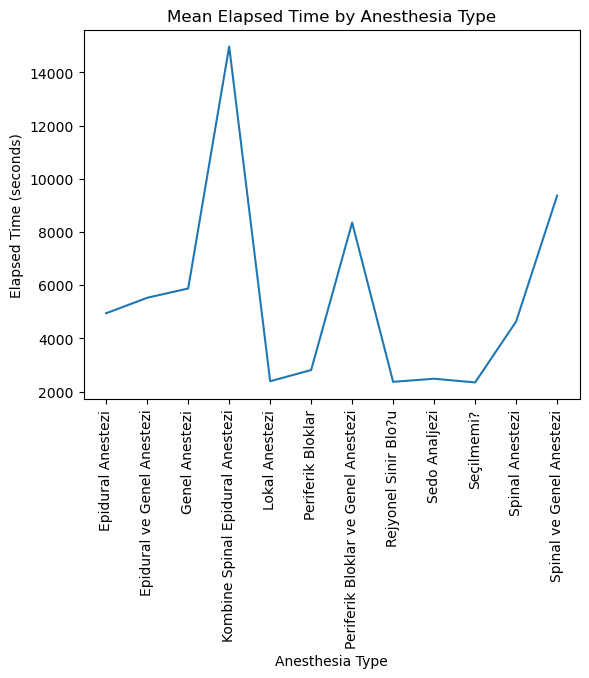

In [16]:
import matplotlib.pyplot as plt

anesthesia_type_mean_time = df.groupby('AnesthesiaType')['ElapsedTime(second)'].mean()

plt.plot(anesthesia_type_mean_time.index, anesthesia_type_mean_time.values)
plt.xticks(rotation=90)
plt.xlabel('Anesthesia Type')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Mean Elapsed Time by Anesthesia Type')
plt.show()


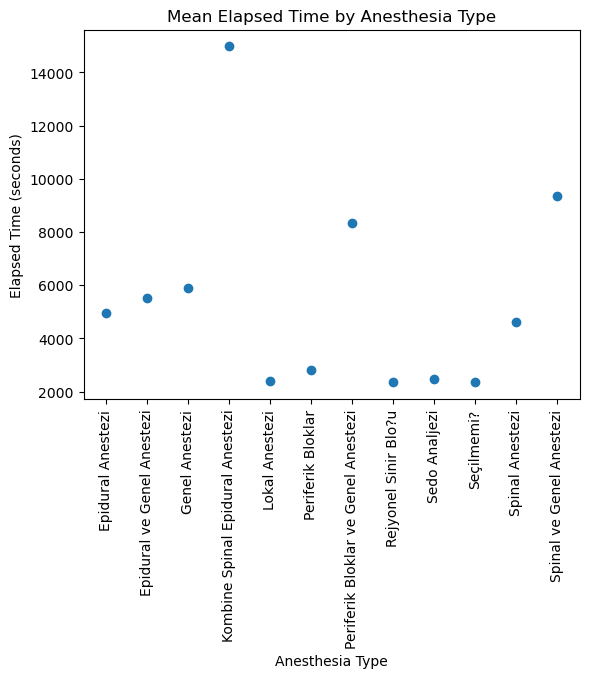

In [17]:
plt.scatter(anesthesia_type_mean_time.index, anesthesia_type_mean_time.values)
plt.xticks(rotation=90)
plt.xlabel('Anesthesia Type')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Mean Elapsed Time by Anesthesia Type')
plt.show()

In [18]:
df.groupby('Age')['ElapsedTime(second)'].mean()

Age
0        166.000000
1       1445.000000
2       1586.571429
3       2010.538462
4       2378.444444
           ...     
80     10167.000000
81      6107.000000
82      2443.000000
83      5840.000000
102     9881.000000
Name: ElapsedTime(second), Length: 85, dtype: float64

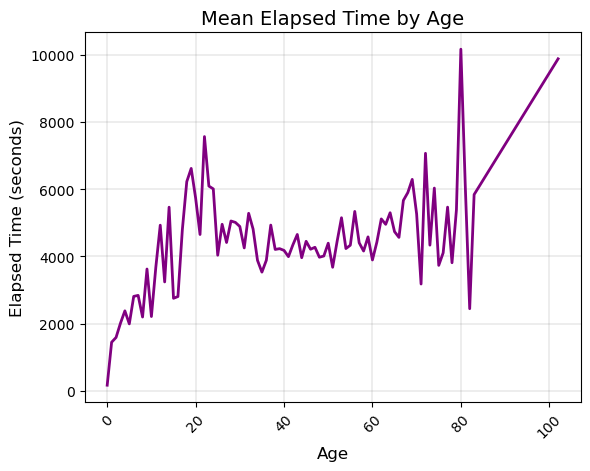

In [19]:
anesthesia_type_mean_time = df.groupby('Age')['ElapsedTime(second)'].mean()

fig, ax = plt.subplots()
ax.plot(anesthesia_type_mean_time.index, anesthesia_type_mean_time.values, color='purple', linewidth=2)

# Grid ekleme
ax.grid(color='gray', linestyle='-', linewidth=0.2)

# X ekseni etiketleri için rotation
plt.xticks(rotation=45)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Elapsed Time (seconds)', fontsize=12)
ax.set_title('Mean Elapsed Time by Age', fontsize=14)

plt.show()

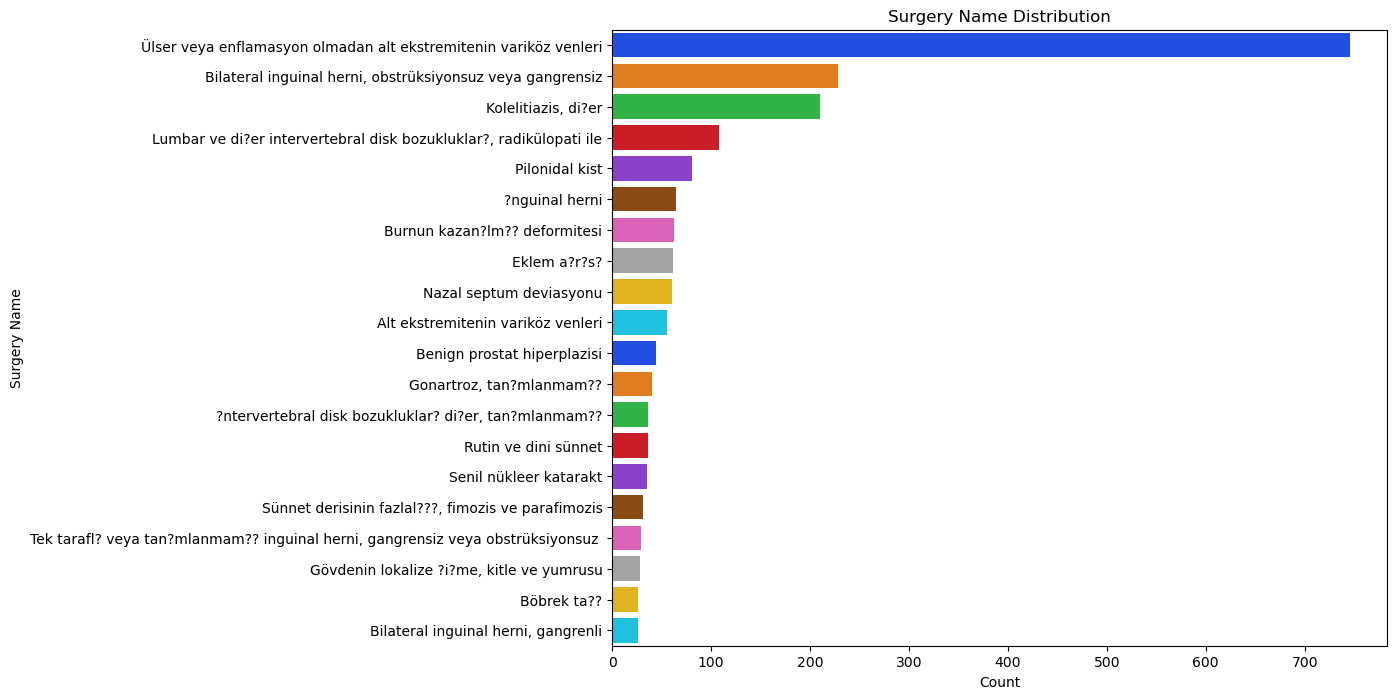

In [20]:
# SurgeryName sütunundaki değerlerin frekansını hesapla
surgery_name_freq = df['SurgeryName'].value_counts()

# En çok geçen ilk 20 değeri al
top_20_surgery_names = surgery_name_freq.head(20)

plt.figure(figsize=(10,8))
sns.countplot(y='SurgeryName', data=df, order=top_20_surgery_names.index, palette='bright')
plt.title('Surgery Name Distribution')
plt.xlabel('Count')
plt.ylabel('Surgery Name')
plt.show()


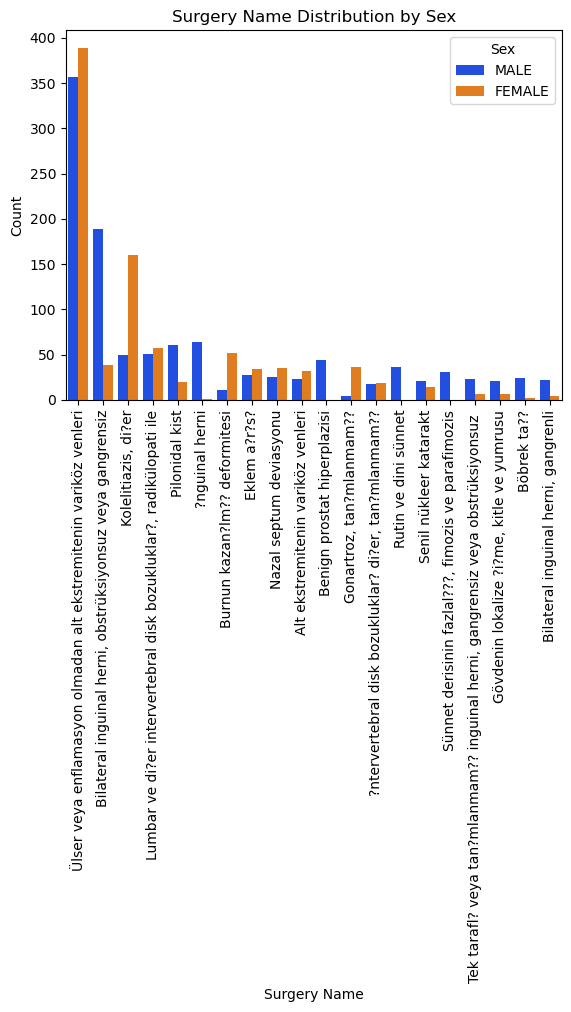

In [21]:
surgery_name_freq = df['SurgeryName'].value_counts()

top_20_surgery_names = surgery_name_freq.head(20)

df_top_20 = df[df['SurgeryName'].isin(top_20_surgery_names.index)]

sns.countplot(x='SurgeryName', hue='Sex', data=df_top_20, order=top_20_surgery_names.index, palette='bright')
plt.xticks(rotation=90)
plt.title('Surgery Name Distribution by Sex')
plt.xlabel('Surgery Name')
plt.ylabel('Count')
plt.show()


In [22]:
import plotly.express as px
import plotly.graph_objs as go

service_counts = df['Service'].value_counts()

service_perc = [round((count/sum(service_counts))*100,2) for count in service_counts]

fig = go.Figure()

fig.add_trace(go.Pie(labels=service_counts.index, 
                     values=service_counts.values, 
                     textposition='inside', 
                     textinfo='percent+label',
                     hole=0.4,
                     pull=[0.1 if i == max(service_counts) else 0 for i in service_counts])) 

fig.add_annotation(text='<b>Service</b><br>'+ '<br>'.join([f"{service_counts.index[i]}: {service_perc[i]}%" for i in range(len(service_counts))]),
                  x=0.5, y=0.5, font=dict(size=12, color='black'), showarrow=False)

fig.update_layout(title='Service Distribution',
                  width=800, 
                  height=400, 
                  margin=dict(l=50, r=50, t=50, b=50),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  annotations=[dict(x=0.5, y=1.1, showarrow=False, 
                                    text='Borda Teknoloji Hastanesi\'nde Hangi Servislerin Hizmeti Sunuluyor?',
                                    font=dict(size=14))]
                 )

fig.show()


In [23]:
import plotly.graph_objects as go

# Anesthesia type distribution as pie chart
fig = go.Figure(data=[go.Pie(labels=df['AnesthesiaType'], 
                             values=df.index,
                             hole=.3)])
fig.update_layout(title='Anesthesia Distribution', width=800, height=400)
fig.show()

# Anesthesia type distribution as sunburst chart
fig = go.Figure(go.Sunburst(
    labels=df['AnesthesiaType'],
    parents=['' for _ in df['AnesthesiaType']],
    values=df.index,
))
fig.update_layout(title='Anesthesia Distribution', width=800, height=400)
fig.show()

# Anesthesia type distribution as treemap chart
fig = go.Figure(go.Treemap(
    labels=df['AnesthesiaType'],
    parents=['' for _ in df['AnesthesiaType']],
    values=df.index,
))
fig.update_layout(title='Anesthesia Distribution', width=800, height=400)
fig.show()


In [24]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': round(100 * (dataframe[col_name].value_counts()) / len(dataframe), 2)}))

    if plot:
        sns.displot(x=col_name,data=dataframe, kde=True)
        plt.title(col_name + ' Histogram Grafiği')
        plt.show()
        sns.stripplot(dataframe, y=col_name, jitter=True, color='purple', alpha=0.5)
        plt.ylabel(col_name)
        plt.title(col_name + ' Nokta Grafiği')

      ElapsedTime(second)  Ratio
1645                    4   0.14
1962                    4   0.14
3530                    4   0.14
4101                    4   0.14
3278                    4   0.14
...                   ...    ...
6534                    1   0.04
3545                    1   0.04
1708                    1   0.04
6849                    1   0.04
5690                    1   0.04

[2330 rows x 2 columns]


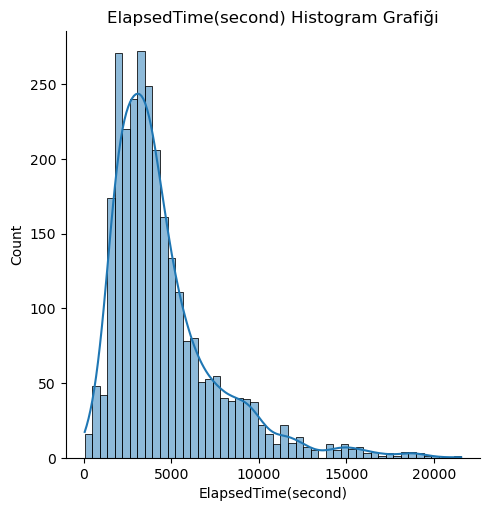

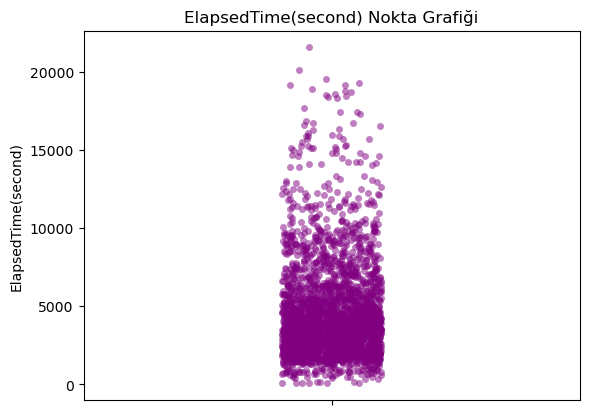

In [25]:
cat_summary(df,"ElapsedTime(second)", plot=True)


Gözlemlediğimiz çizimde Elapsed Time (Geçen Süre) değerlerinin sağa doğru ciddi bir şekilde azaldığını gözlemledik. Bu durum, Elapsed Time değerlerinin sağa çarpık (pozitif çarpıklık) olduğunu göstermektedir. Pozitif çarpıklık, veri dağılımının sağ kısmının sol kısmına göre daha uzun olduğu durumlarda meydana gelir.

Bu durumda, tahmin değerlerimizin Elapsed Time değerlerinin ortalaması yerine ortancası civarında olması gerektiğini söyleyebiliriz. Çünkü Elapsed Time değerlerinin ortancası, dağılımın yoğunluğunun en yüksek olduğu bölgedir.

In [26]:
import plotly.express as px

fig = px.scatter(df, x=df.index, y="ElapsedTime(second)", color="DoctorID",
                 size='ElapsedTime(second)', hover_data=['ElapsedTime(second)'],
                 labels={"ElapsedTime(second)": "Elapsed Time (seconds)", "index": "Sample Number"},
                 color_discrete_sequence=px.colors.qualitative.Dark24,
                 
                 )

fig.update_layout(title='Örnek Numarasına Göre Geçen Süre',
                  xaxis=dict(title='Örnek Numarası'),
                  yaxis=dict(title='Elapsed Time (seconds)'))

fig.show() 

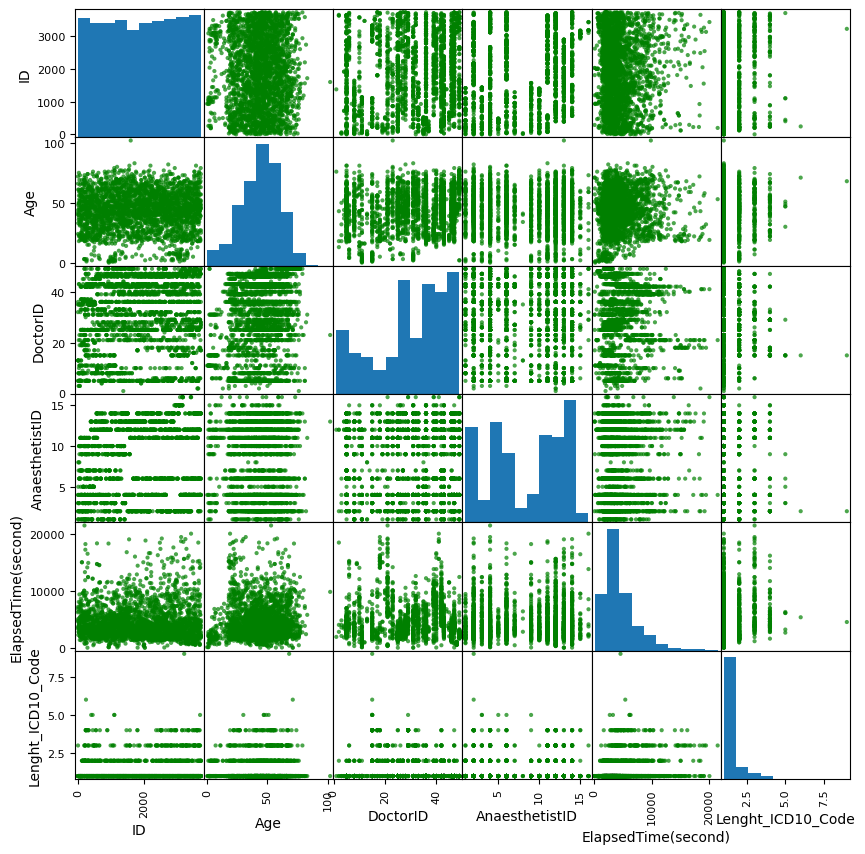

In [27]:
pd.plotting.scatter_matrix(df, figsize=(10,10), diagonal='hist', alpha=0.7, color='g')
plt.show()

In [28]:
list_Index = ["A1", "A2", "A3", "B", "C", "D", "E"]

def SurgeryGroup_OneHotEncoder(data_fream):

    # Let's create the our storage lists
    list_New_columns = [[],[],[],[],[],[],[]]    
    
    # Go throug the all the values on our columns
    for val in data_fream.SurgeryGroup.values :
        
        # Split the our values create the list to easy check
        val = str(val).split(',')      
        
        # Fast tour on our list
        for index in range(len(list_Index)) : 
            
            # Check the is value NaN or not
            if 'nan' in val: 
                list_New_columns[index].append(np.nan)
            
            # Quick check the we have the value in our data point
            elif list_Index[index] in val : 
                list_New_columns[index].append(1)
            
            else : 
                list_New_columns[index].append(0)

    return list_New_columns


In [29]:
new_col_list = SurgeryGroup_OneHotEncoder(df)

In [30]:
# Little for loop go trough our  list
for index in range(len(list_Index)) :

    df[list_Index[index]] = new_col_list[index]

In [31]:
df.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),Lenght_ICD10_Code,ICD10_Code_Spell,A1,A2,A3,B,C,D,E
0,1829,"L05,","C,",Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333,1,[L],0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1104,"N20.1,","C,",Spinal Anestezi,Ülser veya enflamasyon olmadan alt ekstremiten...,24,MALE,ÜROLOJ? SERV?S?,15,3,2972,1,[N],0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1850,"K80.8,","B,",Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647,1,[K],0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1059,"M51.1,","B,",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871,1,[M],0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,608,"M51.1,M48.0,","B,C,D,A3,",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046,2,"[M, M]",0.0,0.0,1.0,1.0,1.0,1.0,0.0


# Label Encoding

In [32]:
labelencoder = LabelEncoder()

In [33]:
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
    df[i] = df["ICD10_Code_Spell"].apply(lambda x: sum([1 for code in ' '.join(str(x)).split() if code.startswith(i)]))
    print(i, df[i].sum())


A 5
B 0
C 18
D 7
E 9
F 1
G 14
H 122
I 790
J 169
K 936
L 241
M 598
N 330
O 2
P 0
Q 4
R 64
S 67
U 0
V 0
Z 115


In [34]:
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
    df[i] = df[i].apply(lambda x: 1 if x > 1 else x)

In [35]:
df.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),Lenght_ICD10_Code,ICD10_Code_Spell,A1,A2,A3,B,C,D,E,A,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,1829,"L05,","C,",Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333,1,[L],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1104,"N20.1,","C,",Spinal Anestezi,Ülser veya enflamasyon olmadan alt ekstremiten...,24,MALE,ÜROLOJ? SERV?S?,15,3,2972,1,[N],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1850,"K80.8,","B,",Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647,1,[K],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1059,"M51.1,","B,",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871,1,[M],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,608,"M51.1,M48.0,","B,C,D,A3,",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046,2,"[M, M]",0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [36]:
df["AnesthesiaType"] = labelencoder.fit_transform(df["AnesthesiaType"])
df["Service"] = labelencoder.fit_transform(df["Service"])
df["SurgeryNameEncoded"] = labelencoder.fit_transform(df["SurgeryName"])


In [37]:
df.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),Lenght_ICD10_Code,ICD10_Code_Spell,A1,A2,A3,B,C,D,E,A,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z,SurgeryNameEncoded
0,1829,"L05,","C,",10,Pilonidal kist,26,MALE,0,5,13,6333,1,[L],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,172
1,1104,"N20.1,","C,",10,Ülser veya enflamasyon olmadan alt ekstremiten...,24,MALE,9,15,3,2972,1,[N],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,242
2,1850,"K80.8,","B,",2,"Kolelitiazis, di?er",38,MALE,0,36,14,4647,1,[K],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,125
3,1059,"M51.1,","B,",2,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,7,42,6,4871,1,[M],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,143
4,608,"M51.1,M48.0,","B,C,D,A3,",2,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,7,42,9,9046,2,"[M, M]",0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,143


# Binary Coding

In [38]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [39]:
label_encoder(df,"Sex")

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),Lenght_ICD10_Code,ICD10_Code_Spell,A1,A2,A3,B,C,D,E,A,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z,SurgeryNameEncoded
0,1829,"L05,","C,",10,Pilonidal kist,26,1,0,5,13,6333,1,[L],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,172
1,1104,"N20.1,","C,",10,Ülser veya enflamasyon olmadan alt ekstremiten...,24,1,9,15,3,2972,1,[N],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,242
2,1850,"K80.8,","B,",2,"Kolelitiazis, di?er",38,1,0,36,14,4647,1,[K],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,125
3,1059,"M51.1,","B,",2,Lumbar ve di?er intervertebral disk bozuklukla...,41,0,7,42,6,4871,1,[M],0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,143
4,608,"M51.1,M48.0,","B,C,D,A3,",2,Lumbar ve di?er intervertebral disk bozuklukla...,49,0,7,42,9,9046,2,"[M, M]",0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,73,"I83.9,","B,C,",2,Ülser veya enflamasyon olmadan alt ekstremiten...,59,0,7,32,7,8079,1,[I],0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,242
2818,12,"I83.9,","E,",2,"Alt ekstremitenin variköz venleri, ülserli",48,0,1,8,5,2304,1,[I],0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,20
2819,110,"I83.9,","B,",2,"Bilateral inguinal herni, obstrüksiyonsuz veya...",55,1,0,33,11,5211,1,[I],0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,50
2820,2572,"I83.9,","B,",2,"Derinin ve subkutanöz dokunun lokalize ?i?me, ...",49,0,0,29,2,3308,1,[I],0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,71


In [40]:
def SurgeryGroup_Laplace(dataFrame, s):
    # Return list storage for our function
    return_list_col_SurgeryGroup = []
    
    # Quick go trough the values
    for val in dataFrame.SurgeryGroup.values:
        # Assign the our sum variable
        res_val = 0 
        
        # Little "try except" block for our NaN values
        try:
            list_val = val.split(',')[:-1] 
        except AttributeError:
            res_val = np.nan
            list_val = []
        
        # Quick go trough of in our data point values
        for str_val in list_val: 
            # Determine the our frequency values with little math
            val = ord(str_val[0:1])-64
            freq = val/4
            if len(str_val) > 2:
                freq_2 = int(str_val[1:3])/20
            else:
                freq_2 = 0
            
            # Little calculation
            res_val += ((s+freq)/((s+freq)**2 + freq_2**2))
        
        return_list_col_SurgeryGroup.append(res_val)
        
    return return_list_col_SurgeryGroup


In [41]:
def ICD10_Code_Laplace(dataFrame, s):
    # Return list storage for our function
    return_list_col = []
    
    # Quick go trough the values
    for val in dataFrame.DiagnosticICD10Code.values:
        # Assign the our sum variable
        res_val = 0 
        
        # Little "try except" block for our NaN values
        try:
            list_val = val.split(',')[:-1] 
        except AttributeError:
            res_val = np.nan
            list_val = []
        
        # Quick go trough of in our data point values
        for str_val in list_val: 
            # Determine the our frequency values with little math
            val = ord(str_val[0:1])-64
            freq = val/4
            freq_2 = int(str_val[1:3])/20
            
            # Little calculation
            res_val += ((s+freq)/((s+freq)**2 + freq_2**2))
        
        return_list_col.append(res_val)
        
    return return_list_col


In [42]:
df["ICD10_Code_Laplace"]=ICD10_Code_Laplace(df,0.5)


In [43]:
df["SurgeryGroup_Laplace"]=SurgeryGroup_Laplace(df, 0.5)

In [44]:
df.drop(["DiagnosticICD10Code","SurgeryGroup","SurgeryName"], axis=1, inplace=True)


In [45]:
df = df.drop('ICD10_Code_Spell', axis=1)


In [46]:
df.head()

,ID,AnesthesiaType,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),Lenght_ICD10_Code,A1,A2,A3,B,C,D,E,A,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z,SurgeryNameEncoded,ICD10_Code_Laplace,SurgeryGroup_Laplace
0,1829,10,26,1,0,5,13,6333,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,172,0.284264,0.8
1,1104,10,24,1,9,15,3,2972,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,242,0.235294,0.8
2,1850,2,38,1,0,36,14,4647,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,125,0.122353,1.0
3,1059,2,41,0,7,42,6,4871,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,143,0.182349,1.0
4,608,2,49,0,7,42,9,9046,2,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,143,0.371528,3.8


In [47]:
check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    2822 non-null   int64  
 1   AnesthesiaType        2822 non-null   int64  
 2   Age                   2822 non-null   int64  
 3   Sex                   2822 non-null   int64  
 4   Service               2822 non-null   int64  
 5   DoctorID              2822 non-null   int64  
 6   AnaesthetistID        2822 non-null   int64  
 7   ElapsedTime(second)   2822 non-null   int64  
 8   Lenght_ICD10_Code     2822 non-null   int64  
 9   A1                    2759 non-null   float64
 10  A2                    2759 non-null   float64
 11  A3                    2759 non-null   float64
 12  B                     2822 non-null   int64  
 13  C                     2822 non-null   int64  
 14  D          

# Data Filling

In [48]:
# İteratif imputasyon modeli
# NaN değerleri iteratif olarak doldur
imp = IterativeImputer(RandomForestRegressor(), max_iter=20, random_state=0)
df_imputed_array = imp.fit_transform(df)
df_imputed = pd.DataFrame(data=df_imputed_array, columns=df.columns)

In [49]:
 #Let's scaling with RobustScaler
df_imputed["Age"] = RobustScaler().fit_transform(df_imputed[["Age"]])

 # Model Selection

In [50]:
# target and independent variables:

y = df_imputed["ElapsedTime(second)"]
X = df_imputed.drop(["ElapsedTime(second)","ID"], axis=1)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 15,
                                                    test_size = 0.2, 
                                                    shuffle = True)

print(f"The shape of X_train is --> {(X_train.shape)}")
print(f"The shape of X_test is  --> {(X_test.shape)}")
print(f"The shape of y_train is --> {(y_train.shape)}")
print(f"The shape of y_test is  --> {(y_test.shape)}")

The shape of X_train is --> (2257, 35)
The shape of X_test is  --> (565, 35)
The shape of y_train is --> (2257,)
The shape of y_test is  --> (565,)


In [52]:

def evaluate_models(X_train, X_test, y_train, y_test):
    models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(verbose= False),
]
    
    for model in models:
        model_name = type(model).__name__
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        print(f'{model_name}:')
        print(f'Train RMSE: {train_rmse:.2f}')
        print(f'Test RMSE: {test_rmse:.2f}')
        print(f'Train R^2: {train_r2:.2f}')
        print(f'Test R^2: {test_r2:.2f}')
        print('-------------------------------------------------------')

In [53]:
evaluate_models(X_train, X_test, y_train, y_test)

LinearRegression:
Train RMSE: 2092.44
Test RMSE: 2042.88
Train R^2: 0.52
Test R^2: 0.56
-------------------------------------------------------
Ridge:
Train RMSE: 2093.08
Test RMSE: 2040.66
Train R^2: 0.52
Test R^2: 0.56
-------------------------------------------------------
Lasso:
Train RMSE: 2093.78
Test RMSE: 2040.34
Train R^2: 0.52
Test R^2: 0.56
-------------------------------------------------------
ElasticNet:
Train RMSE: 2388.48
Test RMSE: 2318.39
Train R^2: 0.37
Test R^2: 0.43
-------------------------------------------------------
DecisionTreeRegressor:
Train RMSE: 74.09
Test RMSE: 2116.01
Train R^2: 1.00
Test R^2: 0.53
-------------------------------------------------------
RandomForestRegressor:
Train RMSE: 620.39
Test RMSE: 1611.70
Train R^2: 0.96
Test R^2: 0.73
-------------------------------------------------------
GradientBoostingRegressor:
Train RMSE: 1490.13
Test RMSE: 1584.14
Train R^2: 0.76
Test R^2: 0.74
-------------------------------------------------------
XGBR

# Test İmport

In [54]:
df_test= pd.read_csv("/kaggle/input/prediction-of-surgery-duration/test.csv",encoding='Latin-1')

In [55]:
# AnesthesiaType sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df_test["AnesthesiaType"].isnull().sum().astype(str))

df_test["AnesthesiaType"].fillna("Genel Anestezi", inplace=True)

print("Boşluk doldurma sonrası boş değer sayısı:" + df_test["AnesthesiaType"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:95
Boşluk doldurma sonrası boş değer sayısı:0


In [56]:
# SurgeryName sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df_test["SurgeryName"].isnull().sum().astype(str))
df_test['SurgeryName'] = df_test['SurgeryName'].fillna(df_test['SurgeryName'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df_test["SurgeryName"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:149
Boşluk doldurma sonrası boş değer sayısı:0


In [57]:
# DiagnosticICD10Code sütunundaki eksik değerleri mod ile doldurma
print("Boşluk doldurma öncesi boş değer sayısı:" + df_test["DiagnosticICD10Code"].isnull().sum().astype(str))
df_test['DiagnosticICD10Code'] = df_test['DiagnosticICD10Code'].fillna(df_test['DiagnosticICD10Code'].mode()[0])
print("Boşluk doldurma sonrası boş değer sayısı:" + df_test["DiagnosticICD10Code"].isnull().sum().astype(str))

Boşluk doldurma öncesi boş değer sayısı:95
Boşluk doldurma sonrası boş değer sayısı:0


In [58]:
df_test[['DiagnosticICD10Code', 'Lenght_ICD10_Code', 'ICD10_Code_Spell']] = df_test['DiagnosticICD10Code'].apply(DiagnosticICD10Code).apply(pd.Series)
SurgeryGroup(df_test)

nan

In [59]:
df_test.replace("{0}", np.nan, inplace= True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   1211 non-null   int64 
 1   DiagnosticICD10Code  1211 non-null   object
 2   SurgeryGroup         1183 non-null   object
 3   AnesthesiaType       1211 non-null   object
 4   SurgeryName          1211 non-null   object
 5   Age                  1211 non-null   int64 
 6   Sex                  1211 non-null   object
 7   Service              1211 non-null   object
 8   DoctorID             1211 non-null   int64 
 9   AnaesthetistID       1211 non-null   int64 
 10  Lenght_ICD10_Code    1211 non-null   int64 
 11  ICD10_Code_Spell     1211 non-null   object
dtypes: int64(5), object(7)
memory usage: 113.7+ KB


In [60]:
df_test['SurgeryGroup'] = df_test['SurgeryGroup'].apply(SurgeryGroup)

In [61]:
df_test.replace(",", np.nan, inplace= True)

In [62]:
new_col_list = SurgeryGroup_OneHotEncoder(df_test)

In [63]:
# Little for loop go trough our  list
for index in range(len(list_Index)) :

    df_test[list_Index[index]] = new_col_list[index]

In [64]:
df_test["AnesthesiaType"] = labelencoder.fit_transform(df_test["AnesthesiaType"])
df_test["Service"] = labelencoder.fit_transform(df_test["Service"])
df_test["SurgeryNameEncoded"] = labelencoder.fit_transform(df_test["SurgeryName"])
label_encoder(df_test,"Sex")

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,Lenght_ICD10_Code,ICD10_Code_Spell,A1,A2,A3,B,C,D,E,SurgeryNameEncoded
0,1669,"H26.9,","C,",6,Ülser veya enflamasyon olmadan alt ekstremiten...,70,0,3,49,13,1,[H],0.0,0.0,0.0,0.0,1.0,0.0,0.0,179
1,2091,"L05.9,","C,",7,Pilonidal kist,41,1,1,36,6,1,[L],0.0,0.0,0.0,0.0,1.0,0.0,0.0,129
2,585,"M50.1,","A3,",2,"Servikal disk bozukluklar?, radikülopati ile",59,0,8,42,14,1,[M],0.0,0.0,1.0,0.0,0.0,0.0,0.0,150
3,1455,"S42.2,","B,",2,Humerus üst uç k?r???,54,0,8,23,14,1,[S],0.0,0.0,0.0,1.0,0.0,0.0,0.0,84
4,1801,"I82,","E,",6,Ülser veya enflamasyon olmadan alt ekstremiten...,50,1,6,46,13,1,[I],0.0,0.0,0.0,0.0,0.0,0.0,1.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,1599,"I83.9,","B,",2,"Gövdenin lokalize ?i?me, kitle ve yumrusu",23,0,1,36,11,1,[I],0.0,0.0,0.0,1.0,0.0,0.0,0.0,73
1207,41,"I83.9,","B,",2,"Tibian?n alt uç k?r???, kapal?",56,0,8,23,8,1,[I],0.0,0.0,0.0,1.0,0.0,0.0,0.0,165
1208,1,"I83.9,","D,C,",2,Nazal septum deviasyonu,32,0,5,37,1,1,[I],0.0,0.0,0.0,0.0,1.0,1.0,0.0,124
1209,24,"I83.9,","D,C,",2,Anal fissür tan?mlanmam??,18,0,1,3,2,1,[I],0.0,0.0,0.0,0.0,1.0,1.0,0.0,18


In [65]:
df_test["ICD10_Code_Laplace"]=ICD10_Code_Laplace(df_test,0.5)
df_test["SurgeryGroup_Laplace"]=SurgeryGroup_Laplace(df_test, 0.5)

In [66]:
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
    df_test[i] = df_test["ICD10_Code_Spell"].apply(lambda x: sum([1 for code in ' '.join(str(x)).split() if code.startswith(i)]))
    print(i, df_test[i].sum())

for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'Z']:
    df_test[i] = df_test[i].apply(lambda x: 1 if x > 1 else x)

A 4
B 0
C 8
D 3
E 5
F 1
G 6
H 53
I 334
J 71
K 404
L 109
M 266
N 148
O 0
P 0
Q 4
R 29
S 31
U 0
V 0
Z 40


In [67]:
df_test.drop(["DiagnosticICD10Code","SurgeryGroup","SurgeryName","ICD10_Code_Spell"], axis=1, inplace=True)


In [68]:
# İteratif imputasyon modeli
# NaN değerleri iteratif olarak doldur
imp = IterativeImputer(RandomForestRegressor(), max_iter=25, random_state=0)
df_imputed_array_test = imp.fit_transform(df_test)
df_imputed_test = pd.DataFrame(data=df_imputed_array_test, columns=df_test.columns)


In [69]:
 #Let's scaling with RobustScaler
df_imputed_test["Age"] = RobustScaler().fit_transform(df_imputed_test[["Age"]])

In [70]:
df_imputed_test.head()

,ID,AnesthesiaType,Age,Sex,Service,DoctorID,AnaesthetistID,Lenght_ICD10_Code,A1,A2,A3,B,C,D,E,SurgeryNameEncoded,ICD10_Code_Laplace,SurgeryGroup_Laplace,A,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z
0,1669.0,6.0,1.086957,0.0,3.0,49.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,0.314861,0.800000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2091.0,7.0,-0.173913,1.0,1.0,36.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,0.284264,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,585.0,2.0,0.608696,0.0,8.0,42.0,14.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,150.0,0.184615,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1455.0,2.0,0.391304,0.0,8.0,23.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,0.164204,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1801.0,6.0,0.217391,1.0,6.0,46.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,0.112832,0.571429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df_imputed.head()

,ID,AnesthesiaType,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second),Lenght_ICD10_Code,A1,A2,A3,B,C,D,E,A,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z,SurgeryNameEncoded,ICD10_Code_Laplace,SurgeryGroup_Laplace
0,1829.0,10.0,-0.863636,1.0,0.0,5.0,13.0,6333.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172.0,0.284264,0.8
1,1104.0,10.0,-0.954545,1.0,9.0,15.0,3.0,2972.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,242.0,0.235294,0.8
2,1850.0,2.0,-0.318182,1.0,0.0,36.0,14.0,4647.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,0.122353,1.0
3,1059.0,2.0,-0.181818,0.0,7.0,42.0,6.0,4871.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.182349,1.0
4,608.0,2.0,0.181818,0.0,7.0,42.0,9.0,9046.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.371528,3.8


In [72]:
# df_test1 ve df_train veri çerçevelerindeki sütun sayılarını bulun
print("df_test1 sütun sayısı:", df_imputed_test.shape[1])
print("df_train sütun sayısı:", df_imputed.shape[1])

df_test1 sütun sayısı: 36
df_train sütun sayısı: 37


In [73]:
df_imputed_test['ElapsedTime(second)'] = 0

In [74]:
# Özelliklerin ve hedef değişkenin ayrılması
X_train = df_imputed.drop(['ElapsedTime(second)',"ID"], axis=1)
y_train = df_imputed['ElapsedTime(second)']
X_test = df_imputed_test.drop(["ID","ElapsedTime(second)"], axis=1)
y_test = df_imputed_test['ElapsedTime(second)']

In [75]:
X_train


,AnesthesiaType,Age,Sex,Service,DoctorID,AnaesthetistID,Lenght_ICD10_Code,A1,A2,A3,B,C,D,E,A,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,U,V,Z,SurgeryNameEncoded,ICD10_Code_Laplace,SurgeryGroup_Laplace
0,10.0,-0.863636,1.0,0.0,5.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172.0,0.284264,0.800000
1,10.0,-0.954545,1.0,9.0,15.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,242.0,0.235294,0.800000
2,2.0,-0.318182,1.0,0.0,36.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,0.122353,1.000000
3,2.0,-0.181818,0.0,7.0,42.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.182349,1.000000
4,2.0,0.181818,0.0,7.0,42.0,9.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.0,0.371528,3.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,2.0,0.636364,0.0,7.0,32.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,242.0,0.110954,1.800000
2818,2.0,0.136364,0.0,1.0,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.110954,0.571429
2819,2.0,0.454545,1.0,0.0,33.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.110954,1.000000
2820,2.0,0.181818,0.0,0.0,29.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,0.110954,1.000000


In [76]:
df_imputed_test.isnull().sum()


ID                      0
AnesthesiaType          0
Age                     0
Sex                     0
Service                 0
DoctorID                0
AnaesthetistID          0
Lenght_ICD10_Code       0
A1                      0
A2                      0
A3                      0
B                       0
C                       0
D                       0
E                       0
SurgeryNameEncoded      0
ICD10_Code_Laplace      0
SurgeryGroup_Laplace    0
A                       0
F                       0
G                       0
H                       0
I                       0
J                       0
K                       0
L                       0
M                       0
N                       0
O                       0
P                       0
Q                       0
R                       0
S                       0
U                       0
V                       0
Z                       0
ElapsedTime(second)     0
dtype: int64

In [77]:
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

LGBMRegressor(random_state=42)

In [78]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [79]:
df_imputed_test['ElapsedTime(second)'] = model.predict(X_test)

In [80]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")


RMSE: 3272.966324217252


In [81]:
df_imputed_test['ElapsedTime(second)']

0       2430.253889
1       2429.506507
2       3640.784021
3       3357.547443
4       2823.110589
           ...     
1206    3662.862658
1207    3740.378321
1208    3896.518632
1209    3639.715294
1210    4253.520214
Name: ElapsedTime(second), Length: 1211, dtype: float64

In [82]:
df_imputed_test['ID'] = df_imputed_test['ID'].astype('Int32')


In [83]:
train_sizes, train_scores, test_scores = learning_curve(
    LGBMRegressor(), X, y, cv=5, scoring='r2', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

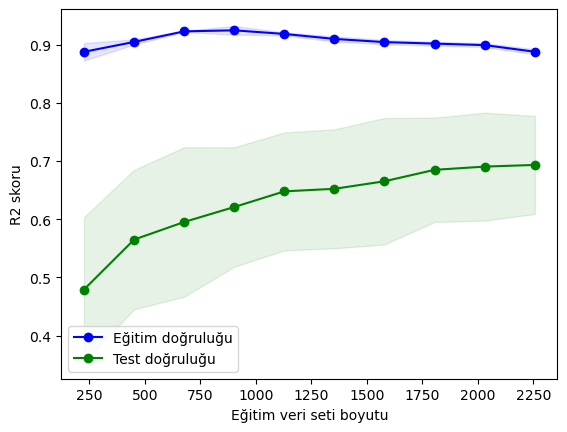

In [84]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Eğitim doğruluğu')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Test doğruluğu')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.1, color='green')
plt.xlabel('Eğitim veri seti boyutu')
plt.ylabel('R2 skoru')
plt.legend(loc='best')
plt.show()

Veri setinin R^2 Skoru gittikçe artmıştır bu modelimizin  genelleme yeteneğinin arttığını ve yeni verilerde iyi performans gösterebileceği anlamına gelir

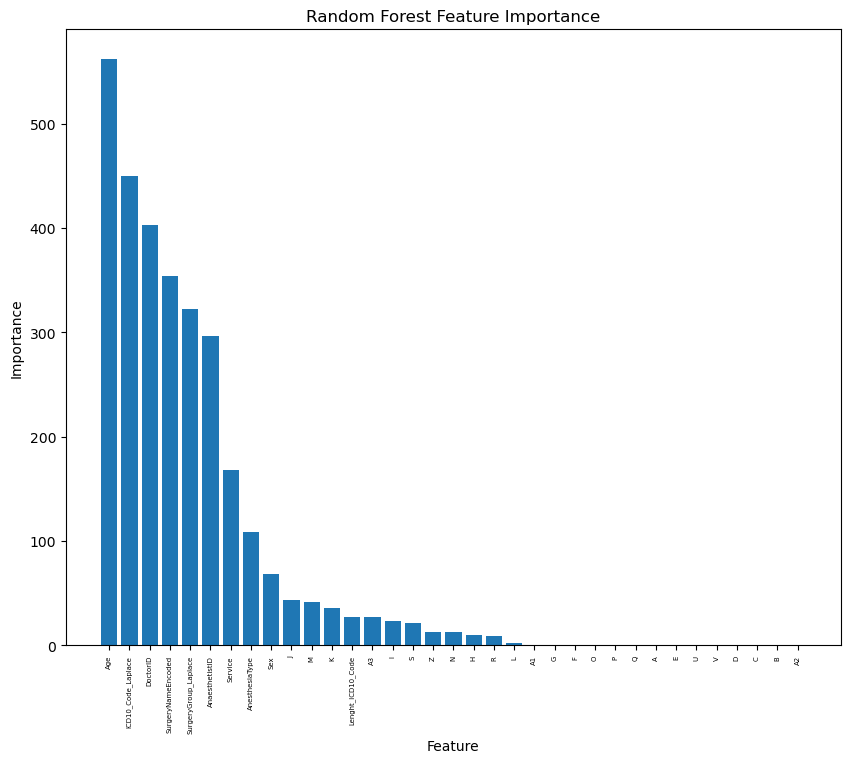

In [85]:
# özellik önemlerini bir dizi olarak al
importances = model.feature_importances_

# özelliklerin isimlerini bir dizi olarak al
feature_names = X_train.columns

# özellik isimleri ve önemleri içeren bir veri çerçevesi oluştur
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Önemliliğe göre sırala
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Veri çerçevesini kullanarak bir bar grafik oluştur
plt.figure(figsize=(10,8))
plt.bar(x=feature_importances['feature'], height=feature_importances['importance'])
plt.xticks(rotation=90,fontsize=5)
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [86]:
# submission.csv dosyasının oluşturulması
submission = pd.DataFrame({'ID': df_imputed_test['ID'], 'ElapsedTime(second)': df_imputed_test['ElapsedTime(second)']})
submission.to_csv('submission.csv', index=False)